# Deep mutual learning

Deep mutual learning (DML)とは，複数のネットワークを使った相互学習手法です．Knowledge distillationでは，Teacherネットワークという事前学習済みの大きなネットワークの出力を，小さなStudentネットワークに真似させることで，Studentネットワークの性能を向上させていました．DMLでは，未学習のStudentネットワークだけを使って，2つのネットワークの出力をお互いに真似し合いながら学習します．以下に，クラス分類問題を解くネットワークにおけるDMLの概要を示します．DMLの学習は，基本的にknowledge distillationと似ていますが，2つのStudentネットワークを同時に学習するところが異なります．その際，2つのネットワークの出力のKL divergenceを損失関数として用います．2つのStudentのサイズは，同じでも異なっていてもうまく機能します．

<img src="https://paper-attachments.dropbox.com/s_87B2D47FBD0A698415C3853F712E17ACC67F633356B04D1BA9138A68175CE0AD_1596763062871_image.png" width = 40%>

## 学習方法

DMLは，各イテレーションで2つのネットワークを同時に学習させます．
2つのStudentネットワークを$\theta_1, \theta_2$とすると，以下の手順を繰り返します．

1. Student $\theta_1, \theta_2$に画像を入力
2. Student $\theta_1$の損失を計算 ＆ backprop
3. Student $\theta_1$を更新
4. 更新後のStudent $\theta_1$に再び画像を入力
5. Student $\theta_2$の損失を計算 ＆ backprop
6. Student $\theta_2$を更新


### 損失関数

Student 1と2の損失関数は同じであるため，Student 1の損失関数のみを説明します．DMLでは，蒸留と同じく2種類の損失関数の和を最終的な損失関数としています．

1つ目は，教師ラベル(hard target)との損失を計算するためのcross entropy lossです．これは，通常の教師あり学習で使用するものと同じです．具体的な式は以下のように表されます．

$$L^{\theta_1}_{hard} = - \sum^C_i{t_i \log{p^{\theta_1}_i(x)}}$$

ここで，$C$はクラス数，$t_i \in \{0,1\}$は$i$番目クラスの教師ラベル値，$x$は入力画像，$p^{\theta_1}_i$はStudent $\theta_1$の出力をsoftmax関数で正規化した後の，$i$番目クラスの確率値です．

2つ目は，相互学習用の損失を計算するためのKullback-Leibler divergence lossです．具体的な式は以下のように表されます．

$$L^{\theta_1}_{soft} = D_{KL}(p^{\theta_2} || p^{\theta_1}) = \sum^C_i{p^{\theta_2}_i(x) \log{\frac{p^{\theta_1}_i(x)}{p^{\theta_2}_i(x)}}}$$

最終的なLossは以下のように，2つの損失関数の和です．
$$L^{\theta_1} = L^{\theta_1}_{hard} + L^{\theta_1}_{soft}$$

#### KL divergence
相互学習用の損失関数に使用したKullback-Leibler divergence (KL divergence)とは，2つの確率分布間の相違度を表す指標です．下の図のように，確率分布 $P,Q$ が似ている場合（左図）にはKL divergence $D_{KL}(P||Q)$ は小さくなり，似ていない場合（右図）には大きくなります．KL divergenceは距離ではないため$D_{KL}(P||Q)$と$D_{KL}(Q||P)$は通常異なります．DMLでは，このKL divergenceの値が小さくなるように（つまり，2つのネットワークの出力が似るように）ネットワークを学習します．

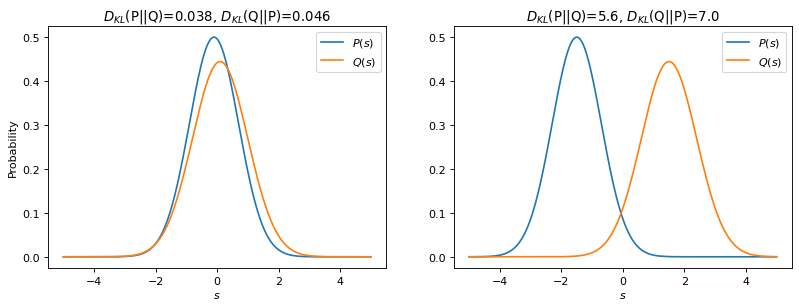

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, entropy

s = np.linspace(-5, 5, 500)
p_1 = norm.pdf(s, loc=-0.1, scale=0.8)
q_1 = norm.pdf(s, loc=0.1, scale=0.9)
kl_p1q1 = entropy(p_1, q_1) # KL divergence
kl_q1p1 = entropy(q_1, p_1) # KL divergence

s = np.linspace(-5, 5, 500)
p_2 = norm.pdf(s, loc=-1.5, scale=0.8)
q_2 = norm.pdf(s, loc=1.5, scale=0.9)
kl_p2q2 = entropy(p_2, q_2) # KL divergence
kl_q2p2 = entropy(q_2, p_2) # KL divergence

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4), dpi=80)
ax1.plot(s, p_1)
ax1.plot(s, q_1)
ax1.set_xlabel("$s$")
ax1.set_ylabel("Probability")
ax1.legend(["$P(s)$", "$Q(s)$"])
ax1.set_title("$D_{KL}$(P||Q)="+f"{kl_p1q1:.2}"+", $D_{KL}$(Q||P)="+f"{kl_q1p1:.2}")
ax2.plot(s, p_2)
ax2.plot(s, q_2)
ax2.set_xlabel("$s$")
ax2.legend(["$P(s)$", "$Q(s)$"])
ax2.set_title("$D_{KL}$(P||Q)="+f"{kl_p2q2:.2}"+", $D_{KL}$(Q||P)="+f"{kl_q2p2:.2}")
fig.show()

### ３つ以上のネットワークを使った学習への拡張

DMLは3つ以上のネットワークで学習させることも可能です．学習方法は，先ほど説明した2つのネットワークを学習させる場合と同様ですが，相互学習用の損失関数の計算が以下のように少し複雑になります．

$$L^{\theta_k}_{soft} = \frac{1}{K-1} \sum^K_{l=1, l \neq k} D_{KL}(p^{\theta_l} || p^{\theta_k})$$

ここで$K$はネットワーク数です．この式は，自分以外のネットワークとのKL diverdenceを求め，その平均値をLossとすることを表しています．

# 畳み込みニューラルネットワークのdeep mutual learning
クラス分類問題を解くネットワークに対して，deep mutual learningを適用した学習を行います．
データセットには一般物体認識用のデータセットであるCIFAR-10を使います．CIFAR-10は10クラスの画像からなるデータセットです．

In [1]:
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchsummary

In [2]:
# エポック数の設定
NUM_EPOCH = 50

In [3]:
# データローダーの準備
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

train_data = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root="./dataset/CIFAR-10", train=False, transform=test_transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=10)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False, num_workers=10)

Files already downloaded and verified
Files already downloaded and verified


## ネットワークの用意
畳み込みネットワークを定義します．ここでは，2層の畳み込み層と3層の全結合層により構成されるネットワークとします．
widen_factorという引数は，畳み込み層のフィルタ数と全結合層のユニット数をデフォルトの値から何倍するかを決定するものです．

In [4]:
class CNN(nn.Module):
    def __init__(self, widen_factor=1):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16*widen_factor, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16*widen_factor, 32*widen_factor, kernel_size=3, stride=1, padding=1)
        self.l1 = nn.Linear(8*8*32*widen_factor, 1024*widen_factor)
        self.l2 = nn.Linear(1024*widen_factor, 1024*widen_factor)
        self.l3 = nn.Linear(1024*widen_factor, 10)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        h = self.pool(self.act(self.conv1(x)))
        h = self.pool(self.act(self.conv2(h)))
        h = h.view(h.size()[0], -1)
        h = self.act(self.l1(h))
        h = self.act(self.l2(h))
        h = self.l3(h)
        return h

## Studentネットワーク単体の学習（DMLなしの場合）
後で比較をするために，Studentネットワークに対して，deep mutual learningを適用しない通常の学習を行います．
Studentネットワークを1つだけ用意して，正解ラベルとのクロスエントロピー損失のみで学習します．

### Studentネットワークの用意
Studentネットワークを作成します．Teacherネットワークよりも小さなネットワークにするため widen_factor=1 にします．

In [5]:
#ネットワークモデルを指定
student = CNN(widen_factor=1).cuda()
# student のサマリーを表示
torchsummary.summary(model=student, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Linear-7                 [-1, 1024]       2,098,176
              ReLU-8                 [-1, 1024]               0
            Linear-9                 [-1, 1024]       1,049,600
             ReLU-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 3,163,114
Trainable params: 3,163,114
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

### 学習 & 評価

In [6]:
# オプティマイザの設定
optimizer = torch.optim.SGD(student.parameters(), lr=0.01, momentum=0.9)

# ネットワークを学習モードへ変更
student.train()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        
        image = image.cuda()
        label = label.cuda()
        
        y_s = student(image)
        
        # 損失の計算
        loss = F.cross_entropy(y_s, label)
        
        student.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss += loss.item()
        
        pred = torch.argmax(y_s, dim=1)
        count += torch.sum(pred == label)
        
    print(f"epoch: {epoch}, mean loss: {sum_loss/len(train_loader)}, mean accuracy: {count.item()/len(train_loader.dataset)}, elapsed_time :{time()-start}")

# ネットワークを評価モードへ変更
student.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:
        
        image = image.cuda()
        label = label.cuda()
        
        y = student(image)
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

epoch: 1, mean loss: 1.7062900456626091, mean accuracy: 0.36942, elapsed_time :4.424213409423828
epoch: 2, mean loss: 1.3191453308400596, mean accuracy: 0.52278, elapsed_time :9.082408666610718
epoch: 3, mean loss: 1.159928763080436, mean accuracy: 0.58454, elapsed_time :13.48412823677063
epoch: 4, mean loss: 1.0561279934233108, mean accuracy: 0.6236, elapsed_time :18.020206212997437
epoch: 5, mean loss: 0.9795953059745262, mean accuracy: 0.65478, elapsed_time :22.593263626098633
epoch: 6, mean loss: 0.9179628053513329, mean accuracy: 0.67376, elapsed_time :27.0924870967865
epoch: 7, mean loss: 0.8649502888969753, mean accuracy: 0.69548, elapsed_time :31.726054906845093
epoch: 8, mean loss: 0.81743352088477, mean accuracy: 0.71226, elapsed_time :36.225003480911255
epoch: 9, mean loss: 0.789827624054821, mean accuracy: 0.72382, elapsed_time :40.71925950050354
epoch: 10, mean loss: 0.75882277971186, mean accuracy: 0.73308, elapsed_time :45.12921738624573
epoch: 11, mean loss: 0.725751501

## Studentネットワークの学習（DMLありの場合）

### Studentネットワークの用意
今回はStudent 1と2を同じサイズのネットワークにしてDMLを実行します．

In [7]:
# Student_1 を用意
student_1 = CNN(widen_factor=1).cuda()
# Student_2 を用意
student_2 = CNN(widen_factor=1).cuda()

### KL divergence lossの定義

In [8]:
def kl_divergence(logits_1, logits_2):
    softmax_1 = F.softmax(logits_1, dim=1)
    softmax_2 = F.softmax(logits_2, dim=1)
    kl = (softmax_2 * torch.log((softmax_2 / (softmax_1+1e-10)) + 1e-10)).sum(dim=1)
    return kl.mean()

### 学習 & 評価
2つのStudentネットワークを同時に学習させます．今回は，2つのネットワークの構造が同じであるため，student_1 の損失値と精度のみを表示します．

In [9]:
# オプティマイザの設定
optimizer_1 = torch.optim.SGD(student_1.parameters(), lr=0.01, momentum=0.9)
optimizer_2 = torch.optim.SGD(student_2.parameters(), lr=0.01, momentum=0.9)

# studentネットワークを学習モードへ変更
student_1.train()
student_2.train()

start = time()
for epoch in range(1, NUM_EPOCH+1):
    sum_loss = 0.0
    count = 0
    
    for image, label in train_loader:
        
        image = image.cuda()
        label = label.cuda()
        
        # Student 1，２に画像を入力
        y_1 = student_1(image)
        y_2 = student_2(image)
        
        # Student 1の損失を計算 ＆ backprop
        loss_1 = F.cross_entropy(y_1, label) + kl_divergence(y_1, y_2.detach())
        student_1.zero_grad()
        loss_1.backward()
        # Student 1を更新
        optimizer_1.step()
        
        # 更新後のStudent 1に再び画像を入力
        y_1 = student_1(image)
        
        # Student 2の損失を計算 ＆ backprop
        loss_2 = F.cross_entropy(y_2, label) + kl_divergence(y_2, y_1.detach())
        student_2.zero_grad()
        loss_2.backward()
        # Student 2を更新
        optimizer_2.step()
        
        sum_loss += loss_1.item()
        
        pred = torch.argmax(y_1, dim=1)
        count += torch.sum(pred == label)
        
    print(f"epoch: {epoch}, mean loss: {sum_loss/len(train_loader)}, mean accuracy: {count.item()/len(train_loader.dataset)}, elapsed_time :{time()-start}")

# ネットワークを評価モードへ変更
student_1.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:
        
        image = image.cuda()
        label = label.cuda()
        
        y = student_1(image)
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

epoch: 1, mean loss: 1.7636436315448694, mean accuracy: 0.38394, elapsed_time :9.101534843444824
epoch: 2, mean loss: 1.4273909632202304, mean accuracy: 0.52496, elapsed_time :18.395700216293335
epoch: 3, mean loss: 1.2838651734544797, mean accuracy: 0.59446, elapsed_time :27.50475263595581
epoch: 4, mean loss: 1.1773993244104068, mean accuracy: 0.64106, elapsed_time :36.766154289245605
epoch: 5, mean loss: 1.1072002978580993, mean accuracy: 0.6705, elapsed_time :45.946645736694336
epoch: 6, mean loss: 1.0481646541896683, mean accuracy: 0.69628, elapsed_time :55.16236162185669
epoch: 7, mean loss: 1.0067015716334438, mean accuracy: 0.71352, elapsed_time :64.33563017845154
epoch: 8, mean loss: 0.9621552775430557, mean accuracy: 0.73054, elapsed_time :73.71124601364136
epoch: 9, mean loss: 0.9291094328893725, mean accuracy: 0.7448, elapsed_time :82.90313339233398
epoch: 10, mean loss: 0.902424829314127, mean accuracy: 0.75474, elapsed_time :92.31488800048828
epoch: 11, mean loss: 0.87957

## アンサンブルした際のテスト精度
上記の結果は，学習したstudent_1とstudent_2のうち，student_1の損失値や精度を表示していました．
DMLでは，最終的に2つの学習済みネットワークができるため，それらのネットワークのアンサンブル推論を計算することが可能です．
ネットワークのアンサンブル推論とは，以下のように各ネットワークの出力の平均値を最終的な推論結果とするものです．

$$
p^{ens}(x) = \frac{1}{K} \sum^K_k {p^{\theta_k}(x)}
$$

このように，複数の学習済みネットワークの予測を組み合わせることで，推論時の精度を向上させることができます．

以下のコードは，2つのネットワークをアンサンブルした際のテスト精度を求めるものです．

In [10]:
# 評価の実行
count = 0
with torch.no_grad():
    for image, label in test_loader:
        
        image = image.cuda()
        label = label.cuda()
        
        y_1 = student_1(image)
        y_2 = student_2(image)
        
        # student_1 と student_2 の予測結果の平均を計算
        y = (y_1 + y_2) / 2
        
        pred = torch.argmax(y, dim=1)
        count += torch.sum(pred == label)

print(f"test accuracy: {count.item()/len(test_loader.dataset)}")

test accuracy: 0.8215


# 課題
上記のプログラムは，2つのStudentネットワークが全く同じ構造になっていました．
Student 2 のネットワークサイズを変更するとStudent 1 のネットワークの精度がどう変化するのかを調べてください．（CNNクラスの引数であるwiden_factorを変更するとネットワークサイズを変えることができます．）